In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import keras
from matplotlib import pyplot as plt
import os

In [2]:
path = r'C:\a-dev\a_study\dataset'
classes = [x for x in os.listdir(path) if x != 'aug']
classes

['hama', 'normal', 'penyakit']

In [3]:
def show_image_samples(generated_data):
    class_indices = generated_data.class_indices
    class_ = list(class_indices.keys())
    imgs, labels = generated_data.next()
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = length if length < 25 else 25
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        idx = int(labels[i])
        c_name = classes[idx]
        plt.title(c_name, color='Blue', fontsize=16)
        plt.axis('off')
    plt.show()


In [4]:
bs = 32

In [5]:
generator = keras.preprocessing.image.ImageDataGenerator(
    validation_split=.2,
    zoom_range=.3,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.,
)

In [6]:
data_train = generator.flow_from_directory(
    os.path.join(path),
    target_size=(512, 512),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    shuffle=True,
    subset='training'
)

data_val = generator.flow_from_directory(
    os.path.join(path),
    target_size=(512, 512),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    shuffle=True,
    subset='validation'
)

Found 12980 images belonging to 3 classes.
Found 3245 images belonging to 3 classes.


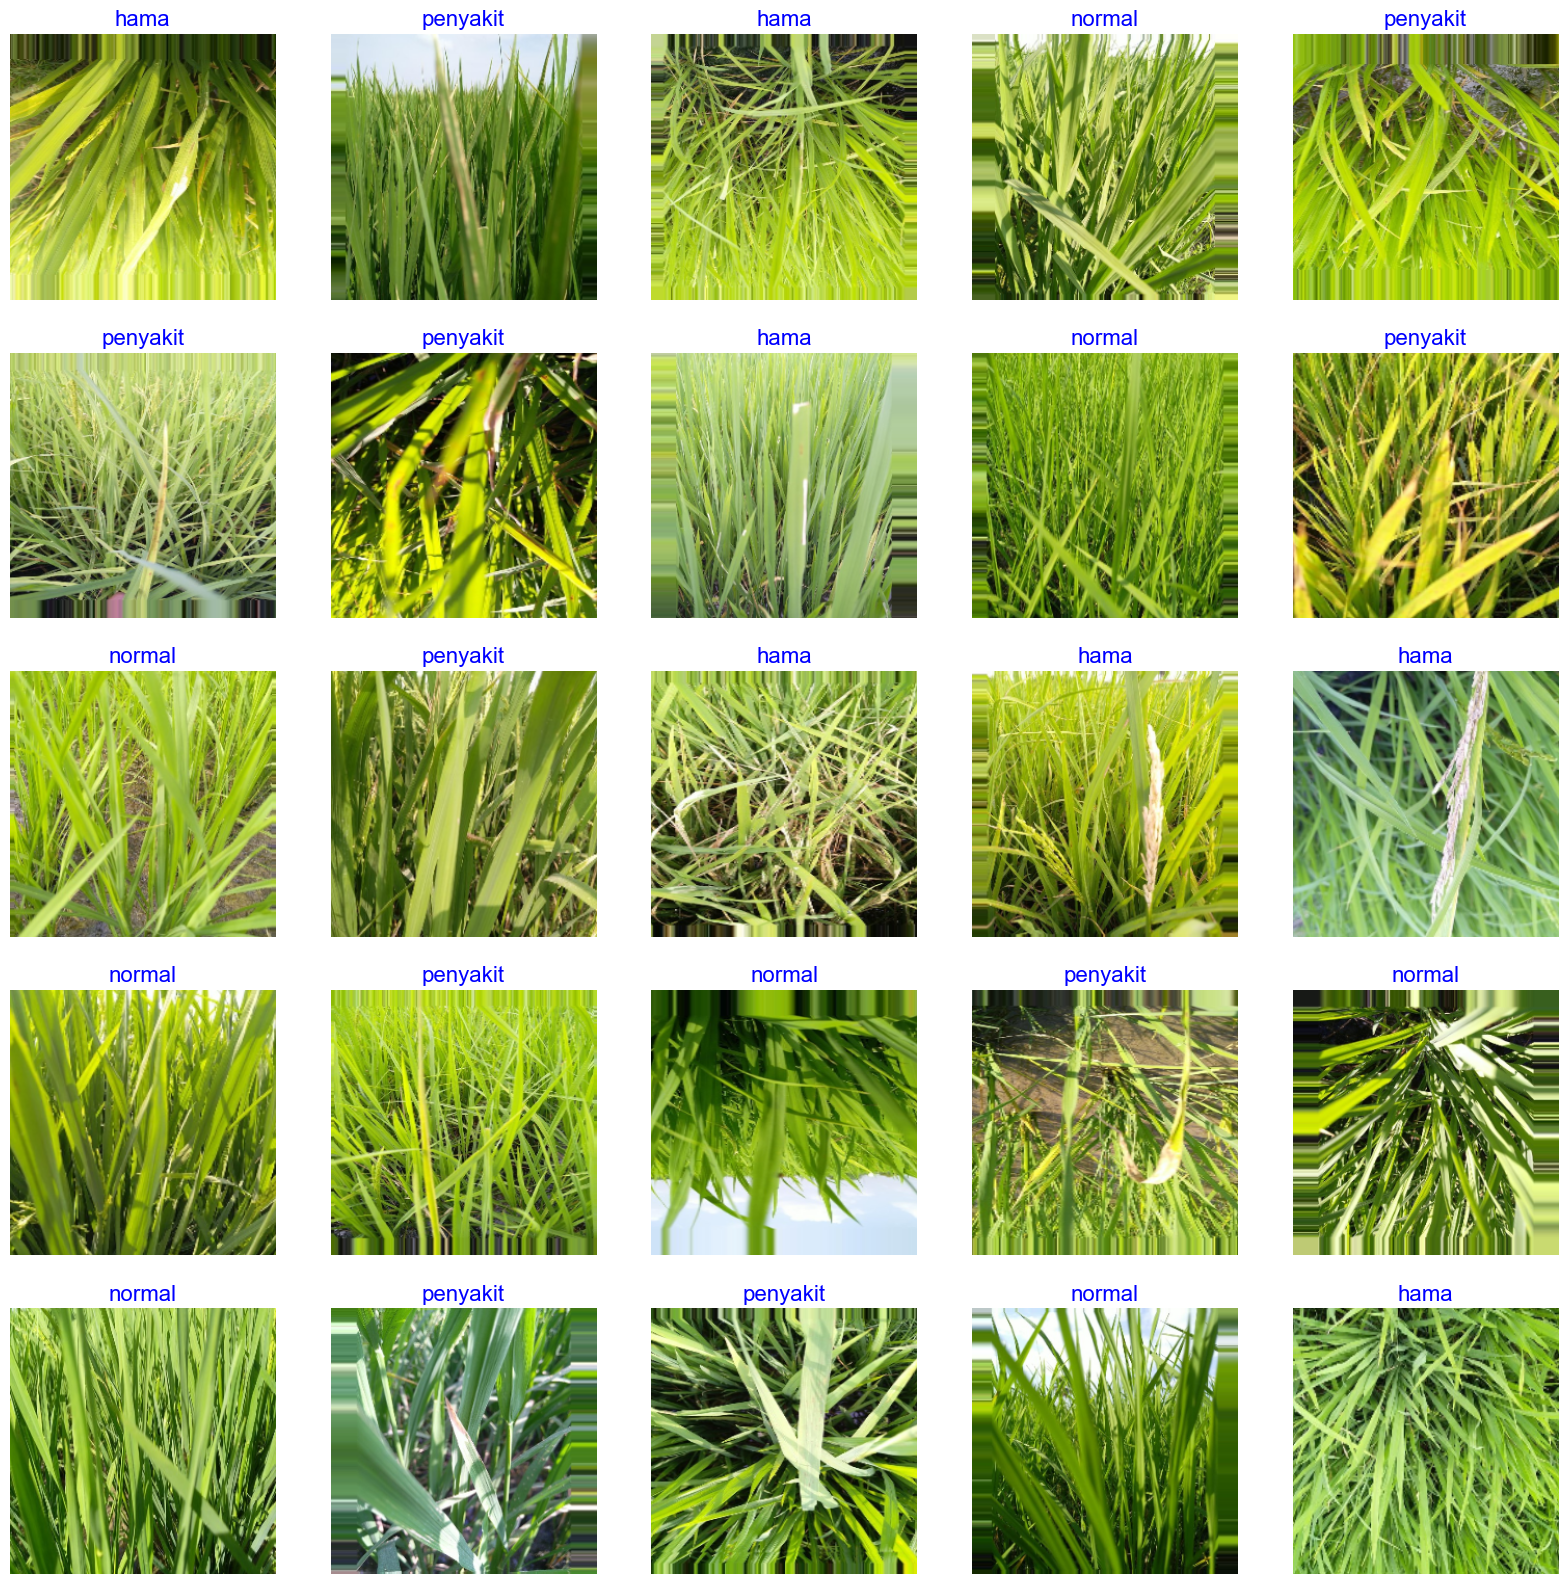

In [7]:
show_image_samples(data_train)

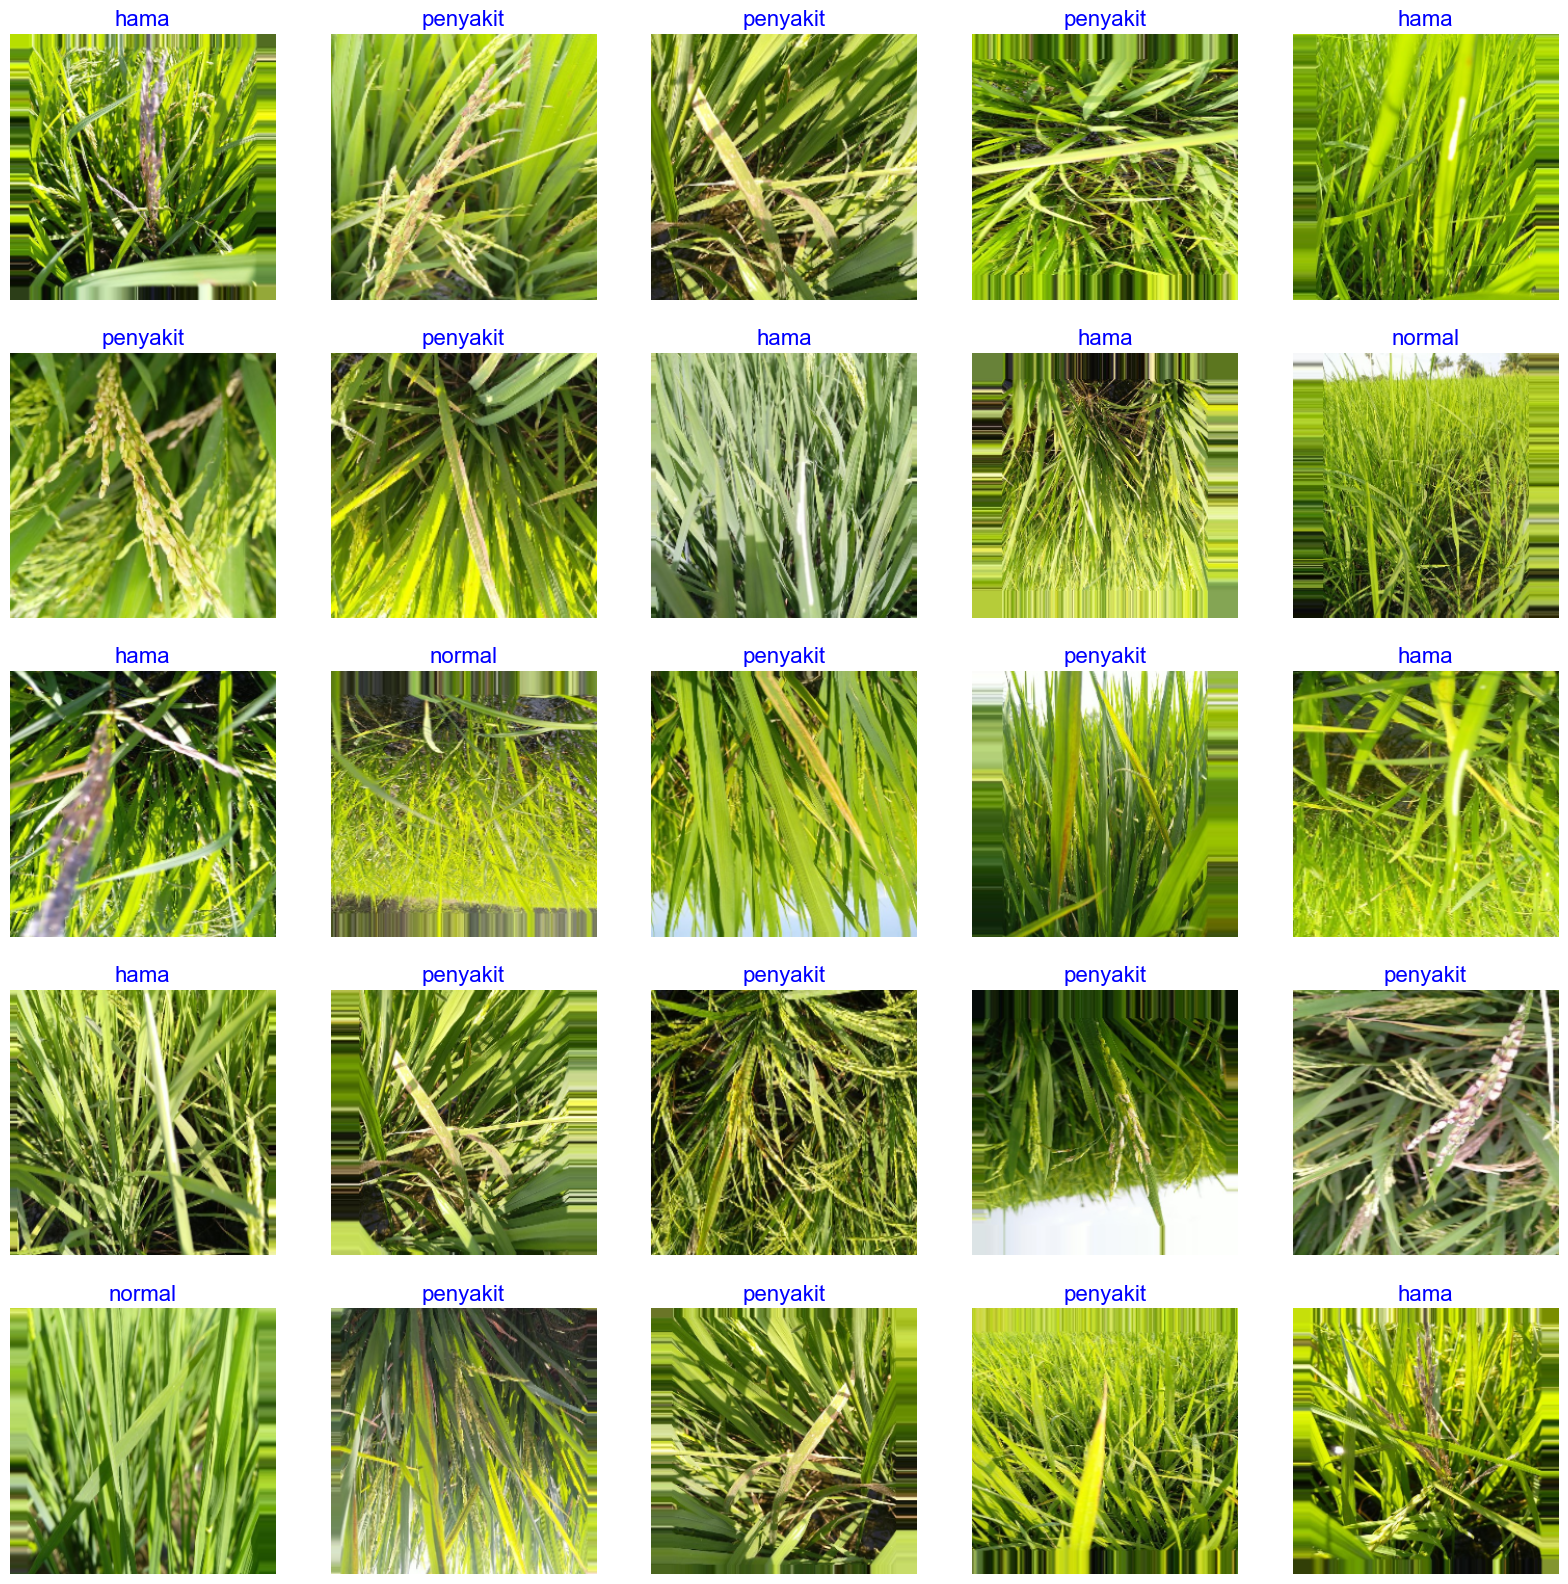

In [8]:
show_image_samples(data_val)

In [9]:
base_model = keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=keras.layers.Input(shape=(512, 512, 3)),
)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
base_model.trainable = False
model = keras.models.Sequential([
    base_model,
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),    
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(len(classes), activation='relu'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                        

In [11]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001))

In [12]:
with tf.device('/gpu:0'):
    H = model.fit(
        data_train,
        validation_data=data_val,
        epochs=5,
        validation_steps=data_val.n // data_val.batch_size,
        steps_per_epoch=data_train.n // data_train.batch_size,
        batch_size=bs
    )

Epoch 1/5
 38/405 [=>............................] - ETA: 6:47 - loss: 3.3447 - accuracy: 0.4743

KeyboardInterrupt: 

In [ ]:
N = 6

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(np.arange(1, N), H.history["loss"], label="Training loss")
ax[0].plot(np.arange(1, N), H.history["val_loss"], label="Validation loss")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(np.arange(1, N), H.history["accuracy"], label="Training accuracy")
ax[1].plot(np.arange(1, N), H.history["val_accuracy"], label="Validation Accuracy")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()